In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(
    n_estimators=500,
    class_weight='balanced',
    random_state=42
)

auc = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print("Mean ROC-AUC:", auc.mean())


Mean ROC-AUC: 0.5977378421472229


=== Model Performance Summary (Mean ROC-AUC) ===
Model A: Baseline + LINC00511              -> 0.5862
Model B: Baseline + MIR-21                 -> 0.6075
Model C: Baseline + MIR-155                -> 0.5892
Model D: Baseline + All Three Biomarkers   -> 0.6424

=== Cross-Validated Performance (ROC-AUC) ===
                      Mean ROC-AUC  Std ROC-AUC
Model                                          
Baseline                    0.5977       0.1752
Baseline + LINC00511        0.5862       0.1981
Baseline + MIR-21           0.6075       0.2038
Baseline + MIR-155          0.5892       0.1425
Baseline + All 3            0.6424       0.1115 



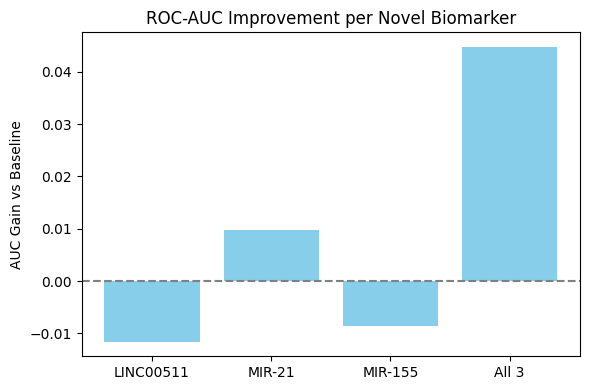

=== Final Model: Baseline + All 3 Novel Biomarkers ===
Mean ROC-AUC:       0.6424
Std ROC-AUC:        0.1115
Gain vs Baseline:   0.0447

=== Feature Importances (Final Model) ===
    Feature  Importance
     MALAT1    0.128058
        PGR    0.120211
       TP53    0.088357
      BRCA2    0.085260
  MIR-21/21    0.077562
     HOTAIR    0.070544
  LINC00511    0.069466
      ERBB2    0.067361
      BRCA1    0.066993
      MKI67    0.062091
     PIK3CA    0.060741
       ESR1    0.052792
MIR-155/155    0.050564


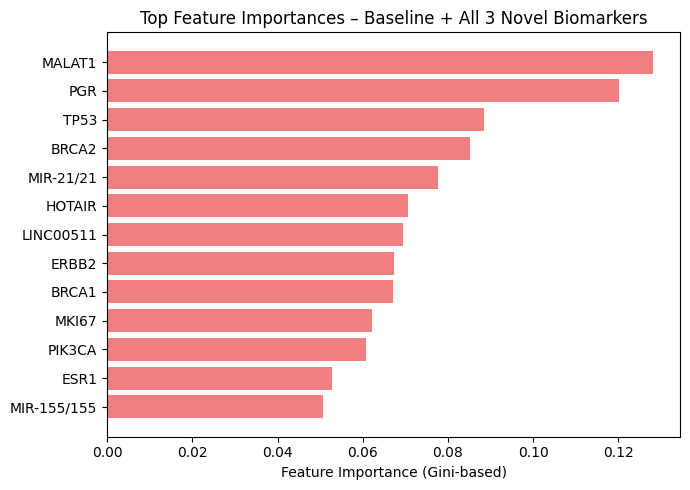

In [ ]:
# =========================================================
# Random Forest Biomarker Analysis – Clean Version
# =========================================================
# Author: Aditya Bapanapalli
# Dataset: TCGA_BRCA_master_dataset_cleaned.csv
# Goal: Evaluate performance gain from adding 3 novel biomarkers
# =========================================================

# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# =========================================================
# 1. Load Preprocessed Data
# =========================================================
# Assumes preprocessing (filtering, encoding, normalization) is done.

df = pd.read_csv("TCGA_BRCA_master_dataset_cleaned.csv")
target_col = "Metastasis_Status"

# Define feature sets
baseline_features = [
    "ESR1", "PGR", "ERBB2", "BRCA1", "BRCA2",
    "TP53", "PIK3CA", "MKI67", "MALAT1", "HOTAIR"
]

novel_LINC = "LINC00511"
novel_MIR21 = "MIR-21/21"
novel_MIR155 = "MIR-155/155"

y = df[target_col]
X_base = df[baseline_features]

# Common Random Forest configuration
rf = RandomForestClassifier(
    n_estimators=500,
    class_weight='balanced',
    random_state=42
)

# =========================================================
# 2. Individual Models – Add Each Novel Biomarker
# =========================================================
def evaluate_model(features, label):
    """Helper function to return mean ROC-AUC for a given feature set."""
    scores = cross_val_score(rf, df[features], label, cv=5, scoring='roc_auc')
    return scores.mean()

auc_A = evaluate_model(baseline_features + [novel_LINC], y)
auc_B = evaluate_model(baseline_features + [novel_MIR21], y)
auc_C = evaluate_model(baseline_features + [novel_MIR155], y)
auc_D = evaluate_model(baseline_features + [novel_LINC, novel_MIR21, novel_MIR155], y)

print("=== Model Performance Summary (Mean ROC-AUC) ===")
print(f"Model A: Baseline + LINC00511              -> {auc_A:.4f}")
print(f"Model B: Baseline + MIR-21                 -> {auc_B:.4f}")
print(f"Model C: Baseline + MIR-155                -> {auc_C:.4f}")
print(f"Model D: Baseline + All Three Biomarkers   -> {auc_D:.4f}\n")

# =========================================================
# 3. Cross-Validated Performance for All Variants
# =========================================================

rf_cfg = dict(
    n_estimators=500,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

models = {
    "Baseline": df[baseline_features],
    "Baseline + LINC00511": df[baseline_features + [novel_LINC]],
    "Baseline + MIR-21": df[baseline_features + [novel_MIR21]],
    "Baseline + MIR-155": df[baseline_features + [novel_MIR155]],
    "Baseline + All 3": df[baseline_features + [novel_LINC, novel_MIR21, novel_MIR155]]
}

cv_results = {}
for name, X_m in models.items():
    rf_m = RandomForestClassifier(**rf_cfg)
    scores = cross_val_score(rf_m, X_m, y, cv=5, scoring='roc_auc')
    cv_results[name] = scores

# =========================================================
# 4. Performance Table (Mean & Std AUC)
# =========================================================
perf_df = (
    pd.DataFrame({
        "Model": list(cv_results.keys()),
        "Mean ROC-AUC": [scores.mean() for scores in cv_results.values()],
        "Std ROC-AUC": [scores.std() for scores in cv_results.values()]
    })
    .set_index("Model")
    .round(4)
)

print("=== Cross-Validated Performance (ROC-AUC) ===")
print(perf_df, "\n")

# =========================================================
# 5. Comparative Bar Chart – AUC Gain vs Baseline
# =========================================================
baseline_mean = cv_results["Baseline"].mean()

labels = ["LINC00511", "MIR-21", "MIR-155", "All 3"]
gains = [
    cv_results["Baseline + LINC00511"].mean() - baseline_mean,
    cv_results["Baseline + MIR-21"].mean() - baseline_mean,
    cv_results["Baseline + MIR-155"].mean() - baseline_mean,
    cv_results["Baseline + All 3"].mean() - baseline_mean
]

plt.figure(figsize=(6, 4))
plt.bar(labels, gains, color='skyblue')
plt.axhline(0, linestyle="--", color='gray')
plt.ylabel("AUC Gain vs Baseline")
plt.title("ROC-AUC Improvement per Novel Biomarker")
plt.tight_layout()
plt.show()

# =========================================================
# 6. Final Model – Baseline + All 3 Biomarkers
# =========================================================
print("=== Final Model: Baseline + All 3 Novel Biomarkers ===")

final_mean = cv_results["Baseline + All 3"].mean()
final_std = cv_results["Baseline + All 3"].std()
improvement = final_mean - baseline_mean

print(f"Mean ROC-AUC:       {final_mean:.4f}")
print(f"Std ROC-AUC:        {final_std:.4f}")
print(f"Gain vs Baseline:   {improvement:.4f}\n")

# Fit final Random Forest for feature importance interpretation
rf_final = RandomForestClassifier(**rf_cfg)
X_final = models["Baseline + All 3"]
rf_final.fit(X_final, y)

fi = (
    pd.DataFrame({
        "Feature": X_final.columns,
        "Importance": rf_final.feature_importances_
    })
    .sort_values("Importance", ascending=False)
)

print("=== Feature Importances (Final Model) ===")
print(fi.to_string(index=False))

# Plot Top Feature Importances
top_k = min(15, fi.shape[0])
fi_top = fi.head(top_k)

plt.figure(figsize=(7, 5))
plt.barh(fi_top["Feature"], fi_top["Importance"], color='lightcoral')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance (Gini-based)")
plt.title("Top Feature Importances – Baseline + All 3 Novel Biomarkers")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# =========================================================
# 0. Define model feature sets (must match your previous cell)
# =========================================================

models_features = {
    "Baseline": baseline_features,
    "Baseline + LINC00511": baseline_features + [novel_LINC],
    "Baseline + MIR-21": baseline_features + [novel_MIR21],
    "Baseline + MIR-155": baseline_features + [novel_MIR155],
    "Baseline + All 3": baseline_features + [novel_LINC, novel_MIR21, novel_MIR155]
}

# =========================================================
# 1. Hyperparameter grid for RF (tune as needed)
#    Includes the example settings you showed.
# =========================================================

param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "class_weight": ["balanced"]
}

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store per-model best fold summaries
best_folds = {}

# =========================================================
# 2. Nested CV-style grid search for each model
# =========================================================

for model_name, feat_list in models_features.items():
    X_model = df[feat_list].values

    fold_results = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X_model, y), start=1):
        X_train, X_test = X_model[train_idx], X_model[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Inner CV grid search on train fold
        base_rf = RandomForestClassifier(random_state=42)
        grid = GridSearchCV(
            estimator=base_rf,
            param_grid=param_grid,
            scoring="roc_auc",
            cv=3,
            n_jobs=-1
        )
        grid.fit(X_train, y_train)

        # Evaluate best estimator on the held-out test fold
        best_rf = grid.best_estimator_
        y_proba = best_rf.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_proba)

        fold_results.append({
            "fold": fold_idx,
            "best_params": grid.best_params_,
            "feature_subset": feat_list,
            "test_auc": test_auc
        })

    # pick the fold with the highest test ROC-AUC for this model
    best_fold = max(fold_results, key=lambda x: x["test_auc"])
    best_folds[model_name] = best_fold

# =========================================================
# 3. Pretty-print best fold summary for each model
# =========================================================

print("=== Best Grid Search Fold per Model ===\n")
for model_name, res in best_folds.items():
    print(f"{model_name}")
    print(f"  Best Fold: {res['fold']}")
    print(f"  Best Feature Subset: {res['feature_subset']}")
    print(f"  Best Parameters: {res['best_params']}")
    print(f"  Test ROC AUC: {res['test_auc']:.4f}")
    print()


=== Best Grid Search Fold per Model ===

Baseline
  Best Fold: 4
  Best Feature Subset: ['ESR1', 'PGR', 'ERBB2', 'BRCA1', 'BRCA2', 'TP53', 'PIK3CA', 'MKI67', 'MALAT1', 'HOTAIR']
  Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
  Test ROC AUC: 0.7449

Baseline + LINC00511
  Best Fold: 4
  Best Feature Subset: ['ESR1', 'PGR', 'ERBB2', 'BRCA1', 'BRCA2', 'TP53', 'PIK3CA', 'MKI67', 'MALAT1', 'HOTAIR', 'LINC00511']
  Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
  Test ROC AUC: 0.7089

Baseline + MIR-21
  Best Fold: 4
  Best Feature Subset: ['ESR1', 'PGR', 'ERBB2', 'BRCA1', 'BRCA2', 'TP53', 'PIK3CA', 'MKI67', 'MALAT1', 'HOTAIR', 'MIR-21/21']
  Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
  Test ROC AUC: 0.7332

Baseline + MIR-155
  Best Fold: 4
  Best Feature Subset: ['ESR1', 'PGR', 'ERBB2', 'BRCA1', 'BRCA2',